# Comparing vanilla and weighted GP regression on simulated data

In [46]:
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import GP regression code
from importlib import reload
import dli_gpr

%matplotlib inline

## Generate simulated data points
(These points are generated randomly so results may look a bit different from run to run.)

In [47]:
# simulate data from two distributions, one with high variance and one with low variance

# noiseless
f = lambda x: 5.*torch.sin(x)

# low variance
f1 = lambda x: 5.*torch.sin(x) + dist.Normal(torch.zeros(x.size(0)), torch.tensor(1.) * torch.ones(x.size(0))).rsample()

# high variance
f2 = lambda x: 5.*torch.sin(x) + dist.Normal(torch.zeros(x.size(0)), torch.tensor(10.) * torch.ones(x.size(0))).rsample()

# sample input points
x1 = torch.FloatTensor(20).uniform_(-5, 5)
x2 = torch.FloatTensor(20).uniform_(-5, 5)

# generate response variables
y1 = f1(x1)
y2 = f2(x2)

# show underlying noiseless function
x0 = torch.linspace(-5, 5, 100)
y0 = f(x0)

## Plot simulated data

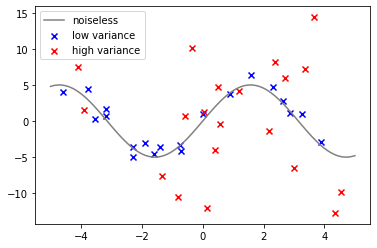

In [48]:
plt.scatter(x1, y1, color="b", marker="x", label="low variance")
plt.scatter(x2, y2, color="r", marker="x", label="high variance")
plt.plot(x0, y0, color="gray", label="noiseless")

plt.legend()

## Prepare model input

In [49]:
# input points
X = torch.cat((x1, x2))

# response variable
y = torch.cat((y1, y2))

# cluster sizes (proportional to variance)
n = torch.cat((torch.ones(x1.size(0)), torch.ones(x2.size(0))*0.1))

## Initialize model

In [100]:
reload(dli_gpr)

weighted_model = dli_gpr.dli_gpr(X, y, n)
vanilla_model = dli_gpr.gpr(X, y)

weighted_model.initialize_variables(1e-4)
vanilla_model.initialize_variables(1e-4)

In [101]:
pyro.clear_param_store()
loss = weighted_model.optimize(1000)

pyro.clear_param_store()
loss = vanilla_model.optimize(1000)

100%|██████████| 1000/1000 [00:01<00:00, 926.28it/s]


## Get conditional distribution for new points

In [102]:
X_new = torch.linspace(-5, 5, 50)
wm, wc = weighted_model.conditional_distribution(X_new)
vm, vc = vanilla_model.conditional_distribution(X_new)

## Visualize original data and conditional distribution

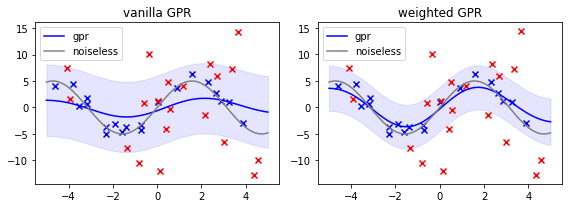

In [103]:
# plot results
fig, axs = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

axs[1].plot(X_new, wm,  "b-", label="gpr")
axs[1].fill_between(X_new, wm - torch.diag(wc)**0.5, wm + torch.diag(wc)**0.5,  color="blue", alpha=0.1)
axs[1].plot(x0, y0, color="gray", label="noiseless")
axs[1].scatter(x1, y1, color="b", marker="x")
axs[1].scatter(x2, y2, color="r", marker="x")
axs[1].set_title("weighted GPR")
axs[1].legend()

axs[0].plot(X_new, vm,  "b-", label="gpr")
axs[0].fill_between(X_new, vm - torch.diag(vc + vanilla_model.sigma)**0.5, vm + torch.diag(vc + vanilla_model.sigma)**0.5, color="blue", alpha=0.1)
axs[0].plot(x0, y0, color="gray", label="noiseless")
axs[0].scatter(x1, y1, color="b", marker="x")
axs[0].scatter(x2, y2, color="r", marker="x")
axs[0].set_title("vanilla GPR")
axs[0].legend()

## Compare log conditional probabilities

In [104]:
wp = weighted_model.conditional_log_prob(x0, y0)
vp = vanilla_model.conditional_log_prob(x0, y0)

print("Log likelihood of noiseless data from weighted model: ", wp.numpy())
print("Log likelihood of noiseless data from unweighted model: ", vp.numpy())

Log likelihood of noiseless data from weighted model:  -236.87936
Log likelihood of noiseless data from unweighted model:  -285.42


In [105]:
from sklearn.metrics import r2_score

# get predictions for noiseless data
w_pred,_ = weighted_model.conditional_distribution(x0)
v_pred,_ = vanilla_model.conditional_distribution(x0)

wr = r2_score(y0.numpy(), w_pred.numpy())
vr = r2_score(y0.numpy(), v_pred.numpy())

print("R2 weighted model: ", wr)
print("R2 vanilla model: ", vr)

R2 weighted model:  0.8604013971687954
R2 vanilla model:  0.4345813217619352
